In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import itertools
from collections import Counter
from scipy import stats
from xgboost import XGBClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_roc_curve(test_label, y_score):
    fpr, tpr, _ = metrics.roc_curve(test_label, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Load oversampled X
oversampled_X_train = np.load('../Data/oversampled_X_train.npy')
# Load oversampled y
oversampled_y_train = np.load('../Data/overssampled_y_train.npy')
# load test set
norm_test = np.load('../Data/norm_test.npy')
y_test = np.load('../Data/y_test.npy')

In [74]:
# Load smote data
final_train = np.load('../Data/smoted_train_X_and_y.npy')
smote_xtrain = final_train[:, :-1]
smote_ytrain = final_train[:, -1]
smote_train_label = smote_ytrain>0
smote_train_label = smote_train_label.astype(np.bool)

dim_reduced_data_test = np.load('../Data/autoencoded_data_test.npy')

In [5]:
train_label = oversampled_y_train >0
test_label = y_test>0

Counter({True: 160014, False: 160014})


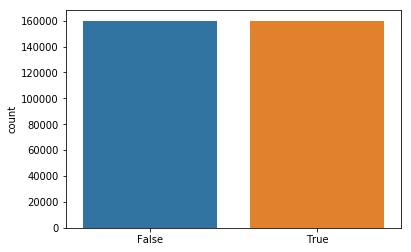

In [6]:
# plot to make sure the training set is balanced
print(Counter(train_label))
sns.countplot(train_label);

In [83]:
rf_model = RandomForestClassifier(random_state=42,  
                             n_estimators=30,
                             max_depth=40, 
                             min_samples_split=3, 
                             min_samples_leaf=2, 
                             bootstrap=True)

rf_model2 = RandomForestClassifier(random_state=42,  
                             n_estimators=30,
                             max_depth=40, 
                             min_samples_split=3, 
                             min_samples_leaf=2, 
                             bootstrap=True)

In [84]:
xgb_model = XGBClassifier(max_depth=40, seed=42)
xgb_model2 = XGBClassifier(max_depth=40, seed=42)

In [85]:
rf_model.fit(oversampled_X_train, train_label)
rf_model2.fit(smote_xtrain, smote_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [86]:
xgb_model.fit(oversampled_X_train, train_label, 
              eval_set=[(norm_test, test_label)], 
              eval_metric=['logloss', 'auc'], 
              early_stopping_rounds=10, verbose=False)
xgb_model2.fit(smote_xtrain, smote_train_label, 
              eval_set=[(dim_reduced_data_test, test_label)], 
              eval_metric=['logloss', 'auc'], 
              early_stopping_rounds=10, verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=40,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [87]:
def predict_score_class_accuracy(model, X, y):
    y_score = model.predict_proba(X)[:,1]
    pred_class = model.predict(X)
    accuracy = model.score(X, y)
    return y_score, pred_class, accuracy

In [88]:
rf_score_os, rf_class_os, rf_accuracy_os = predict_score_class_accuracy(rf_model, norm_test, test_label)
xgb_score_os, xgb_class_os, xgb_accuracy_os = predict_score_class_accuracy(xgb_model, norm_test, test_label)
rf_score_smote, rf_class_smote, rf_accuracy_smote = predict_score_class_accuracy(rf_model2, dim_reduced_data_test, test_label)
xgb_score_smote, xgb_class_smote, xgb_accuracy_smote = predict_score_class_accuracy(xgb_model2, dim_reduced_data_test, test_label)

In [89]:
print('class_accuracy for rf_os: ', np.around(rf_accuracy_os, 4))
print('class_accuracy for xgb_os: ', np.around(xgb_accuracy_os,4))
print('class_accuracy for rf_smote: ', np.around(rf_accuracy_smote, 4))
print('class_accuracy for xgb_smote: ', np.around(xgb_accuracy_smote, 4))

class_accuracy for rf_os:  0.9397
class_accuracy for xgb_os:  0.9411
class_accuracy for rf_smote:  0.853
class_accuracy for xgb_smote:  0.8448


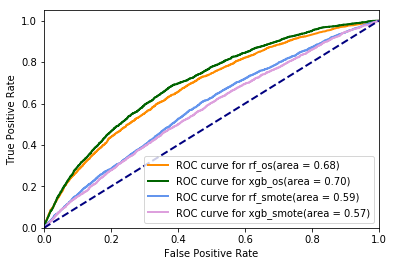

In [91]:
fpr, tpr, _ = metrics.roc_curve(test_label, rf_score_os)
fpr2, tpr2, _ = metrics.roc_curve(test_label, xgb_score_os)
fpr3, tpr3, _ = metrics.roc_curve(test_label, rf_score_smote)
fpr4, tpr4, _ = metrics.roc_curve(test_label, xgb_score_smote)
roc_auc = metrics.auc(fpr,tpr)
roc_auc2 = metrics.auc(fpr2,tpr2)
roc_auc3 = metrics.auc(fpr3,tpr3)
roc_auc4 = metrics.auc(fpr4,tpr4)
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve for rf_os(area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, lw=2, color='darkgreen', label='ROC curve for xgb_os(area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, lw=2, color='cornflowerblue', label='ROC curve for rf_smote(area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, lw=2, color='plum', label='ROC curve for xgb_smote(area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [103]:
precision, recall, f1_score,_ = metrics.precision_recall_fscore_support(test_label, rf_class_os, average='binary')
precision2, recall2, f1_score2,_ = metrics.precision_recall_fscore_support(test_label, xgb_class_os, average='binary')
precision3, recall3, f1_score3,_ = metrics.precision_recall_fscore_support(test_label, rf_class_smote, average='binary')
precision4, recall4, f1_score4,_ = metrics.precision_recall_fscore_support(test_label, xgb_class_smote, average='binary')
print('precision_rf_os: ','%.4f'%precision, ' ', 'precision_xgb_os: ', '%.4f'%precision2, ' ', 'precision_rf_smote: ', '%.4f'%precision3 , ' ', 'precision_xgb_smote: ', '%.4f'%precision4)
print('recall_rf_os: ','%.4f'%recall, '    ', 'recall_xgb_os: ', '%.4f'%recall2, '    ', 'recall_rf_smote: ', '%.4f'%recall3 , '    ', 'recall_xgb_smote: ', '%.4f'%recall4)
print('f1_score_rf_os: ','%.4f'%f1_score, '  ', 'f1_score_xgb_os: ', '%.4f'%f1_score2, '  ', 'f1_score_rf_smote: ', '%.4f'%f1_score3 , '  ', 'f1_score_xgb_smote: ', '%.4f'%f1_score4)

precision_rf_os:  0.2120   precision_xgb_os:  0.2158   precision_rf_smote:  0.0838   precision_xgb_smote:  0.0756
recall_rf_os:  0.0434      recall_xgb_os:  0.0346      recall_rf_smote:  0.1737      recall_xgb_smote:  0.1671
f1_score_rf_os:  0.0721    f1_score_xgb_os:  0.0597    f1_score_rf_smote:  0.1131    f1_score_xgb_smote:  0.1041


In [104]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

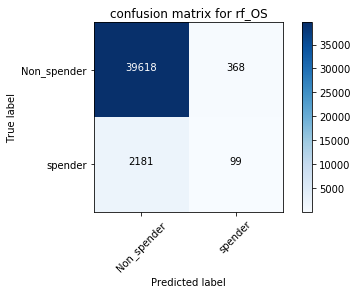

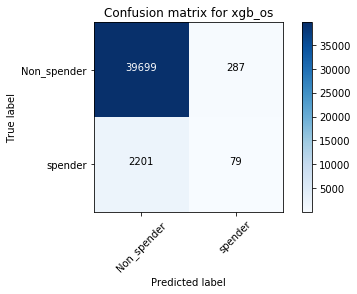

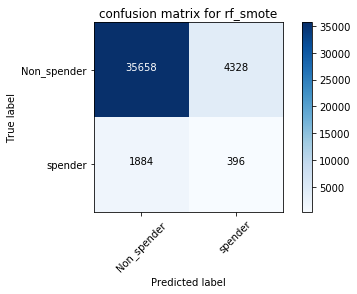

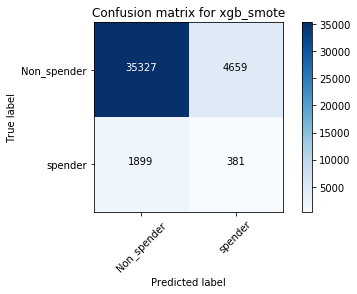

In [106]:
cnf_matrix = metrics.confusion_matrix(test_label, rf_class_os)
cnf_matrix2 = metrics.confusion_matrix(test_label, xgb_class_os)
cnf_matrix3 = metrics.confusion_matrix(test_label, rf_class_smote)
cnf_matrix4 = metrics.confusion_matrix(test_label, xgb_class_smote)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=('Non_spender', 'spender'), title='confusion matrix for rf_OS')
plt.figure()
plot_confusion_matrix(cnf_matrix2,classes=('Non_spender', 'spender'), title='Confusion matrix for xgb_os')
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=('Non_spender', 'spender'), title='confusion matrix for rf_smote')
plt.figure()
plot_confusion_matrix(cnf_matrix4,classes=('Non_spender', 'spender'), title='Confusion matrix for xgb_smote')
plt.show();